In [1]:
import cv2
import imutils

import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping

## Data Extraction

Patients having brain tumor was in yeas folder and vice versa

- 0 : No Tumor
- 1 : Tumor

In [2]:
BaseDir = 'brain-mri-images-for-brain-tumor-detection'
yes_images = 259
n0_images = 22

def load_images():
    images, labels = [], []

    for i in os.listdir(BaseDir + '/yes'):
        img = cv2.imread(filename=BaseDir + '/yes/' + i)
        images.append(img)
        labels.append(1)
    
    for i in os.listdir(BaseDir + '/no'):
        img = cv2.imread(filename=BaseDir + '/no/' + i)
        images.append(img)
        labels.append(0)
    return images, labels

## PreProcessing

In order to center the patients brain we need to crop the important part of the image i.e. the brain

In [3]:
def crop_image(img):
	img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	img_blur = cv2.GaussianBlur(img_gray, (9, 9), 0)
	img_thresh = cv2.threshold(img_blur, 45, 255, cv2.THRESH_BINARY)[1]
	img_erode = cv2.erode(img_thresh, None, iterations=2)
	img_dilate = cv2.dilate(img_erode, None, iterations=2)

	contours = cv2.findContours(img_dilate.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(contours)
	c = max(cnts, key=cv2.contourArea)
	
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])

	x_min, y_min = extLeft[0], extTop[1]
	x_max, y_max = extRight[0], extBot[1]

	return img[y_min:y_max, x_min:x_max]

In [4]:
images, labels = load_images()

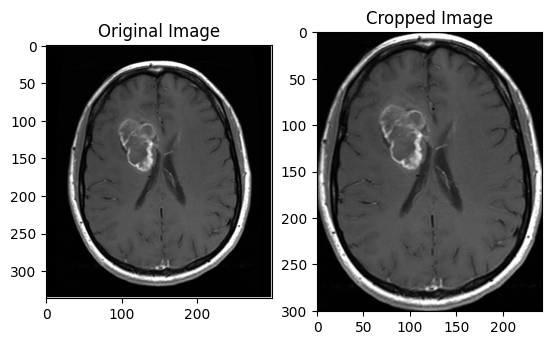

In [5]:
fig, ax = plt.subplots(1,2)

ax[0].title.set_text('Original Image')
ax[0].imshow(images[3])

ax[1].title.set_text('Cropped Image')
ax[1].imshow(crop_image(images[3]))

Cropping and resizing image to (224,224)

In [6]:
IMG_SIZE = (224,224)

images = [cv2.resize(crop_image(i), dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC) for i in images]

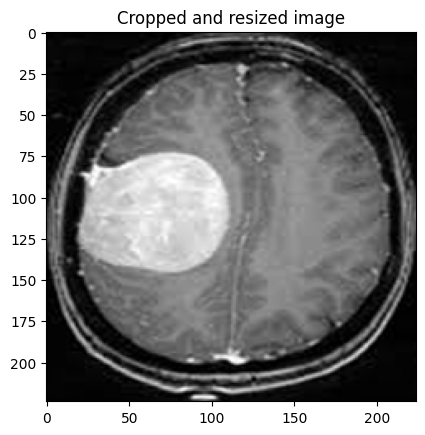

In [41]:
plt.title("Cropped and resized image")
plt.imshow(images[0])

## Model Training 

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    np.array(images), np.array(labels), test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

Since i have very small amount of data I used to take the help of data augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
)


train_generator = train_datagen.flow(np.array(X_train), np.array(y_train), batch_size=32)

In [11]:
config = {
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 20,
    'image_size': (224, 224),
    'num_classes': 1
}

In [12]:
base_model = VGG16(
    include_top=False, 
    input_shape=config['image_size'] + (3,)
)

In [13]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(config['num_classes'], activation='sigmoid'))

In [14]:
model.layers[0].trainable = False

# Build the model with the appropriate input shape
model.build(input_shape=(None,) + config['image_size'] + (3,))

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=config['learning_rate']),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:

es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

In [17]:
history = model.fit(
    train_generator,
    epochs=config['epochs'],
    steps_per_epoch=50,
    callbacks=[es],
    validation_data=(np.array(X_val), np.array(y_val))
)

Epoch 1/20
 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.6517 - loss: 3.3150

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 501ms/step - accuracy: 0.6251 - loss: 3.4727 - val_accuracy: 0.6579 - val_loss: 2.6783
Epoch 2/20


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 662ms/step - accuracy: 0.6498 - loss: 3.7010 - val_accuracy: 0.6842 - val_loss: 2.3400
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 614ms/step - accuracy: 0.6301 - loss: 4.3462 - val_accuracy: 0.7105 - val_loss: 2.3015
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 661ms/step - accuracy: 0.6527 - loss: 4.2418 - val_accuracy: 0.7105 - val_loss: 2.2280
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 795ms/step - accuracy: 0.7121 - loss: 2.6021 - val_accuracy: 0.7105 - val_loss: 1.9870
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 789ms/step - accuracy: 0.7232 - loss: 2.3772 - val_accuracy: 0.7368 - val_loss: 1.7801
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 719ms/step - accuracy: 0.7147 - loss: 2.8567 - val_accuracy: 0.7105 - val_loss: 1.7199
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 730ms/step - accuracy: 0.7829 - loss: 2.7081 - val_accuracy: 0.7368 - val_loss: 1.7607
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 842ms/step - accuracy: 0.7757 - loss: 2.0844 - val_accuracy: 0.76

## Model Eval

In [100]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7588 - loss: 1.8377


[1.8857847452163696, 0.7631579041481018]

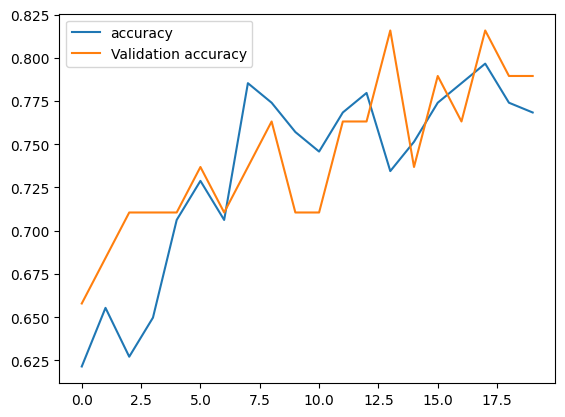

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'Validation accuracy'])

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

pred = model.predict(X_test)

print(classification_report(y_test, pred >= .5))

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.82      0.95      0.88        19

    accuracy                           0.87        38
   macro avg       0.88      0.87      0.87        38
weighted avg       0.88      0.87      0.87        38



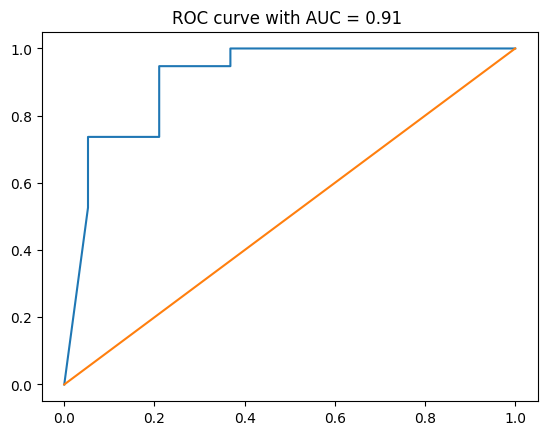

In [34]:
fpr, tpr, _ = roc_curve(y_test, pred)

plt.title("ROC curve with AUC = %.2f " % roc_auc_score(y_test, pred))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])

In [43]:
_

array([          inf, 1.0000000e+00, 9.9963796e-01, 9.9597168e-01,
       7.8835541e-01, 1.8892530e-02, 1.3719627e-02, 8.7487810e-16],
      dtype=float32)

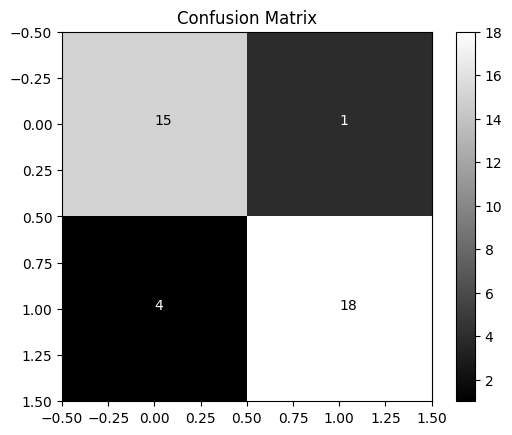

In [36]:
cnf = confusion_matrix(y_test, pred > .5)
plt.title("Confusion Matrix")
plt.imshow(cnf, cmap='gray')
plt.colorbar()
plt.annotate(cnf[0][0], (0,0))
plt.annotate(cnf[0][1], (0,1), color='white')
plt.annotate(cnf[1][0], (1,0), color='white')
plt.annotate(cnf[1][1], (1,1))
plt.show()